In [ ]:
!pip uninstall -y torch torchtext torchaudio --quiet

In [ ]:
pip install torch==2.0.0+cu118 torchtext==0.15.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 684.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=cc81744481259d27ff2f3fade1ea5f1441267f520b3c8a9bf653fcdfd8705998
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.1+cu121 requires torch==2.5.1,

In [ ]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

2.0.0+cu118
0.15.0+cpu


In [ ]:
import torchtext.transforms as T

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import re
import io
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torchtext.datasets import AG_NEWS, IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model
from tqdm.notebook import trange, tqdm
import numpy as np
import os, pathlib, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import text_dataset_from_directory
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
learning_rate = 1e-4
nepochs = 30
batch_size = 128
max_len = 128

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os
import pandas as pd

zip_file_name = '/content/drive/MyDrive/Deep Learning/IMDB Dataset.csv'
shutil.copy(zip_file_name, '/content/')

'/content/IMDB Dataset.csv'

In [ ]:
import os,pandas as pd,pathlib,shutil,random
df=pd.read_csv("/content/IMDB Dataset.csv")
df_train=df[:35000]
df_test=df[35000:]
base_dir=pathlib.Path("aclImdb")
train_dir=base_dir/"train"
test_dir=base_dir/"test"
val_dir=base_dir/"val"
for split_dir in [train_dir,test_dir,val_dir]:
    for category in ("neg","pos"):
        os.makedirs(split_dir/category,exist_ok=True)
def save_files(df,split_dir):
    for i,row in df.iterrows():
        label="pos"if row['sentiment']=="positive"else"neg"
        fname=f"{i}.txt"
        with open(split_dir/label/fname,"w")as f:
            f.write(row['review'])
save_files(df_train,train_dir)
save_files(df_test,test_dir)
for category in ("neg","pos"):
    files=os.listdir(train_dir/category)
    random.Random(1337).shuffle(files)
    num_val_samples=int(0.2*len(files))
    val_files=files[:num_val_samples]
    for fname in val_files:
        shutil.move(train_dir/category/fname,val_dir/category/fname)
print("Data split into train, test, and validation sets.")


Data split into train, test, and validation sets.


In [ ]:
batch_size = 32
train_ds = text_dataset_from_directory(
    "aclImdb/train",batch_size=batch_size)
val_ds = text_dataset_from_directory(
    "aclImdb/val",batch_size=batch_size)
test_ds = text_dataset_from_directory(
    "aclImdb/test",batch_size=batch_size)
text_only_train_ds=train_ds.map(lambda x, y: x)

Found 28000 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Found 15000 files belonging to 2 classes.


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
class IMDBDataset(Dataset):
    def __init__(self,data_dir):
        self.data=[]
        self.labels={"pos":1,"neg":0}
        for label,label_id in self.labels.items():
            folder_path=os.path.join(data_dir,label)
            for filename in os.listdir(folder_path):
                file_path=os.path.join(folder_path,filename)
                with open(file_path,"r",encoding="utf-8")as f:
                    text=f.read().strip()
                    self.data.append((text,label_id))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

data_dir="/content/aclImdb/train"
train_dataset=IMDBDataset(data_dir)
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
for batch_texts,batch_labels in train_loader:
    print("Batch Texts:",batch_texts[:2])
    print("Batch Labels:",batch_labels[:2])
    break


Batch Texts: ('This is a great premise for a movie. The overall plot is very original,interesting, and something to think about. However poor production, an obviously small budget, crapy acting from the main character, and several side actors really detract from this would be classic. An up and coming producer should try to resurect this story and give this basicly half hearted atempt a proper release.', 'We picked this up as a part of a Brentwood set, under the title "The Broken Skull." Shot directly onto video, with widely varying sound and lighting quality, this movie winds up with a hyperactive quality that may inspire the viewer to feelings of nervousness, confusion and irritability - and not in a good, "Evil Dead" kind of way.<br /><br />Without going into spoilers, what appears at first to be a simple revenge ghost story becomes increasingly convoluted and bizarre. While there are some interesting ideas here, the overall effect is likely to leave you scratching your head and say

In [ ]:
data_dir="/content/aclImdb/val"

val_dataset = IMDBDataset(data_dir)
batch_size = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

for batch_texts, batch_labels in val_loader:
    print("Batch Texts:", batch_texts[:2])
    print("Batch Labels:", batch_labels[:2])
    break


Batch Texts: ('I do not generally appreciate light-weight attempts at creating humourous stories, which means that "Anita no perd el Tren" cannot score very high for me. The story is good: a middle-aged but still good-looking woman finds a new love. But the attempts at making this film as a romantic comedy only managed at times to be somewhat comical. <br /><br />Rosa María Sardà has ably demonstrated that she can be a serious actress in such productions as "Amic/Amat" (qv), "Todo Sobre mi Madre" (qv), "Las Amargas Lágrimas de Petra von Kant" (qv) and "El Embrujo de Shanghai" (qv). However the powers that be have over the years dished her out a lot of trivial stuff, for the cinema and for TV. Something similar could be said of José Coronado: perfectly able to produce serious performances. María Barranco belongs safely in this grouping.<br /><br />Such that, in the end, I was left with the feeling that I would be real pleased to see a new making of this film, in a serious tone, which wo

## Data processing and Tokenization

In [ ]:
import os,pandas as pd
from torchtext.data.functional import generate_sp_model
data_path="/content/IMDB Dataset.csv"
output_text_file="/content/data.txt"
df=pd.read_csv(data_path)
with open(output_text_file,"w")as f:
    for review in df['review']:
        f.write(review.strip()+"\n")
generate_sp_model(output_text_file,vocab_size=20000,model_prefix='spm_imdb_news')

In [ ]:
import torchtext.transforms as T
tokenizer=T.SentencePieceTokenizer("spm_imdb_news.model")
batch_texts,batch_labels=next(iter(train_loader))
print("Original Texts:")
for i,text in enumerate(batch_texts[:2]):
    print(f"{i+1}:{text}")
print("\nTokenized Texts:")
for i,text in enumerate(batch_texts[:2]):
    tokens=tokenizer(text)
    print(f"{i+1}:{tokens}")

Original Texts:
1:Bobby and Mikey are two little boys who move across the country with their divorced mother to start a new life. Soon after the family settles in, their mom marries "The King" who ends up being an abusive stepfather, especially to Bobby. So Bobby decides that he will "fly away" from the abuse in his birthday present.<br /><br />This movie was difficult to watch, especially the abuse scenes. It was hard to watch an innocent, playful little boy become abused and turn into a sullen scared, and withdrawn young man. The acting is excellent.<br /><br />I cried throughout the last half of the movie. There were some funny scenes in it too like the Monster Brew and the dog that finds the pop bottles.<br /><br />I wouldn't suggest letting little kids watch it. It was a movie that was painful to watch and yet it really really flew away.
2:If good intentions made a film great, then this film might be one of the greatest films ever made. The film has great actors, a master director

In [ ]:
def yield_tokens(file_path):
    with io.open(file_path,encoding='utf-8')as f:
        for line in f:
            yield[line.split("\t")[0]]
vocab=build_vocab_from_iterator(yield_tokens("spm_imdb_news.vocab"),specials=['<pad>','<sos>','<eos>','<unk>'],special_first=True)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!',
 '!!!!!!',
 '!!!!!!!!!',
 '!!!!!!!!!!!!!!!!',
 '!!)',
 '!"',
 '!")',
 '!)',
 '!),',
 '!).',
 '!).<',
 '!<',
 '"',
 '"!',
 '")',
 '"),',
 '").',
 '",',
 '".',
 '"...',
 '";',
 '"?',
 '&',
 "'",
 '(',
 '(!)',
 '(..',
 '(?)',
 ')',
 '),',
 ').',
 ')...',
 ').<',
 '):',
 ');',
 '*',
 '**',
 '***',
 '****',
 '*****',
 '******',
 '*********',
 '***************',
 '*1/2',
 ',',
 ',000,000',
 '-',
 '--',
 '---',
 '-----',
 '------------',
 '----------------',
 '-1',
 '-10',
 '-13',
 '-19',
 '-80',
 '.',
 '."',
 '...',
 '..."',
 '...)',
 '....',
 '.....',
 '......',
 '.......',
 '........',
 '............',
 '................',
 '.<',
 '/',
 '/10',
 '0',
 '0,000',
 '0.00',
 '00',
 '000',
 '01',
 '02',
 '08',
 '1',
 '1)',
 '1,000',
 '1/2',
 '10',
 '10,000',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '200',
 '22',
 '23',
 '24',
 '25',
 '28',
 '2:37',
 '3',
 '3.99',
 '30',
 '35

In [ ]:
text_tranform=T.Sequential(
    T.SentencePieceTokenizer("spm_imdb_news.model"),
    T.VocabTransform(vocab=vocab),
    T.AddToken(1,begin=True),
    T.Truncate(max_seq_len=max_len),
    T.AddToken(2,begin=False),
    T.ToTensor(padding_value=0),
)

In [ ]:
import torchtext.transforms as T

test_sentences = [
    "is an amazing movie!",
    "The plot was boring and predictable.",
    "I loved the characters and the story.",
    "Not worth watching, terrible acting."
]
max_len = 10
text_tranform = T.Sequential(
    T.SentencePieceTokenizer("spm_imdb_news.model"),  #Adjust this path to your model
    T.VocabTransform(vocab=vocab),
    T.AddToken(1, begin=True),  #Add <sos> token
    T.Truncate(max_seq_len=max_len),  #Truncate sentences longer than max_len
    T.AddToken(2, begin=False),  #Add <eos> token
    T.ToTensor(padding_value=0)  #Pad sentences with <pad> token
)
transformed_sentences = [text_tranform(sentence) for sentence in test_sentences]
for original, transformed in zip(test_sentences, transformed_sentences):
    print(f"Original: {original}")
    print(f"Transformed: {transformed.tolist()}")
    print()

Original: is an amazing movie!
Transformed: [1, 14577, 9931, 9904, 15485, 4, 2]

Original: The plot was boring and predictable.
Transformed: [1, 9038, 16321, 19705, 10585, 9941, 16473, 65, 2]

Original: I loved the characters and the story.
Transformed: [1, 6617, 15006, 18879, 10972, 9941, 18879, 18375, 65, 2]

Original: Not worth watching, terrible acting.
Transformed: [1, 7751, 19923, 19718, 52, 18850, 9695, 65, 2]



In [ ]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.

    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """
    def __init__(self,prob=0.1,pad_token=0,num_special=4):
        self.prob=prob
        self.num_special=num_special
        self.pad_token=pad_token
    def __call__(self,sample):
        mask=torch.bernoulli(self.prob*torch.ones_like(sample)).long()
        can_drop=(sample>=self.num_special).long()
        mask=mask*can_drop
        replace_with=(self.pad_token*torch.ones_like(sample)).long()
        sample_out=(1-mask)*sample+mask*replace_with
        return sample_out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math


class DynamicAttention(nn.Module):
    def __init__(self,numHeads,embedDim,beta,sparsity_factor=0.5):
        super(DynamicAttention,self).__init__()
        self.numHeads=numHeads;self.embedDim=embedDim;self.beta=beta;self.sparsity_factor=sparsity_factor
        self.headDim=embedDim//numHeads
        self.query=nn.Linear(embedDim,embedDim)
        self.key=nn.Linear(embedDim,embedDim)
        self.value=nn.Linear(embedDim,embedDim)
        self.finalProject=nn.Linear(embedDim,embedDim)
        self.filterLayer=nn.Sequential(nn.Linear(embedDim,embedDim//2),nn.ReLU(),nn.Linear(embedDim//2,1),nn.Sigmoid())

    def dynamicSel(self,n,mode="classification"):
        if mode=="classification":
            return random.randint(max(1,int(0.1*n)),max(1,int(0.2*n)))
        elif mode=="generation":
            ma=max(1,0.1*n);mb=random.randint(ma,max(1,int(0.2*n)))
            return ma,mb

    def apply_sparsity(self,attW):
        batchSize,numHeads,seqLen,_=attW.shape
        k=max(1,int(self.sparsity_factor*seqLen))
        _,topk_indices=torch.topk(attW,k,dim=-1)
        mask=torch.zeros_like(attW)
        mask.scatter_(-1,topk_indices,1)
        return attW*mask

    def forward(self,x,mode,return_attn=False):
        batchSize,seqLen,_=x.shape
        q=self.query(x).view(batchSize,seqLen,self.numHeads,self.headDim).transpose(1,2)
        k=self.key(x).view(batchSize,seqLen,self.numHeads,self.headDim).transpose(1,2)
        v=self.value(x).view(batchSize,seqLen,self.numHeads,self.headDim).transpose(1,2)
        score=torch.matmul(q,k.transpose(-2,-1))/torch.sqrt(torch.tensor(self.headDim,dtype=torch.float32))
        attW=F.softmax(score,dim=-1)
        tokenFeatures=x;
        filterWeights=self.filterLayer(tokenFeatures).squeeze(-1).unsqueeze(1).unsqueeze(1)
        attW=attW*filterWeights
        attW=self.apply_sparsity(attW)
        globAtt=attW.sum(dim=-1);totalAtt=globAtt.sum(dim=1)
        if mode=="classification":
            m=self.dynamicSel(seqLen,mode);_,tokenT=torch.topk(totalAtt,m,dim=-1);tokenT=tokenT.tolist()
        elif mode=="generation":
            ma,mb=self.dynamicSel(seqLen,mode);_,tokenT=torch.topk(totalAtt,ma+mb,dim=-1);tokenT=tokenT[:,ma:].tolist()
        reAttw=attW.clone()
        for i in range(batchSize):
            for j in tokenT[i]:
                reAttw[i,:,:,j]*=self.beta
        reOut=torch.matmul(reAttw,v).transpose(1,2).contiguous().view(batchSize,seqLen,self.embedDim)
        out=self.finalProject(reOut)
        return (out,attW) if return_attn else out



# SinusoidalPosEmb class as provided
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# TransformerBlock modified to use DynamicAttention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, beta=1.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size)
        self.dynamic_attn = DynamicAttention(numHeads=num_heads, embedDim=hidden_size, beta=beta)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LayerNorm(hidden_size), nn.ELU(), nn.Linear(hidden_size, hidden_size))

    def forward(self, x, key_padding_mask, mode="classification", return_attn=False):
        norm_x = self.norm1(x)
        attn_output,attnW = self.dynamic_attn(norm_x, mode,return_attn=True)  # Using DynamicAttention
        x = attn_output + x
        norm_x = self.norm2(x)
        mlp_output = self.mlp(norm_x)
        output = mlp_output + x
        if return_attn:
            return output, attnW  # Return attention output if requested
        return output

# Transformer model modified to use DynamicAttention
class Transformer(nn.Module):
    def __init__(self, num_emb, output_size, hidden_size, num_layers, num_heads, beta):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        self.blocks = nn.ModuleList([TransformerBlock(hidden_size, num_heads, beta) for _ in range(num_layers)])
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, mode="classification", return_attn=False):
        bs, _ = input_seq.shape
        key_padding_mask = input_seq == 0
        key_padding_mask = torch.cat((torch.zeros(bs, 1, device=input_seq.device).bool(), key_padding_mask), 1)
        input_embs = self.embedding(input_seq)
        input_embs = torch.cat((self.out_vec.expand(bs, 1, -1), input_embs), 1)
        bs, l, h = input_embs.shape
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        attn_map = []
        for block in self.blocks:
            embs, attn_weight = block(embs, key_padding_mask, mode, return_attn=True)
            attn_map.append(attn_weight)
        if return_attn:
            return self.fc_out(embs[:, 0]), attn_map
        return self.fc_out(embs[:, 0])


## Initialize Model and Optimizer

In [ ]:
device=torch.device("cuda:0"if torch.cuda.is_available()else"cpu")
hidden_size=512
tf_classifier=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8,beta=0.2).to(device)
optimizer=optim.Adam(tf_classifier.parameters(),lr=learning_rate)
lr_scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=nepochs,eta_min=0)
loss_fn=nn.CrossEntropyLoss()
scaler=torch.cuda.amp.GradScaler()
td=TokenDrop(prob=0.5)
training_loss_logger=[]
test_loss_logger=[]
training_acc_logger=[]
test_acc_logger=[]


In [ ]:
num_model_params = 0
for param in tf_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 20506632 (Approximately 20 Million) Parameters!


## Train Model

In [ ]:
nepochs = int(nepochs)
pbar=trange(0,nepochs,leave=False,desc="Epoch")
train_acc=0
test_acc=0
accumulation_steps=4
for epoch in pbar:
    train_acc_count=0
    test_acc_count=0
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%'%(train_acc*100,test_acc*100))
    tf_classifier.train()
    steps=0
    optimizer.zero_grad()
    for batch in tqdm(train_loader,desc="Training",leave=False):
        text,label=batch
        bs=len(label)
        text_tokens=text_tranform(list(text)).to(device)
        label=label.to(device)
        text_tokens=td(text_tokens)
        with torch.cuda.amp.autocast():
            pred,attn_w=tf_classifier(text_tokens,return_attn=True,mode="classification")
            loss=loss_fn(pred,label)
        loss=loss/accumulation_steps
        scaler.scale(loss).backward()
        training_loss_logger.append(loss.item())
        train_acc_count+=(pred.argmax(1)==label).sum().item()
        steps+=bs
        if(steps%accumulation_steps==0)or(steps==len(train_loader)-1):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
    train_acc=train_acc_count/steps
    training_acc_logger.append(train_acc)
    lr_scheduler.step()
    tf_classifier.eval()
    steps=0
    with torch.no_grad():
        for batch in tqdm(val_loader,desc="Testing",leave=False):
            text,label=batch
            bs=len(label)
            text_tokens=text_tranform(list(text)).to(device)
            label=label.to(device)
            with torch.cuda.amp.autocast():
                pred=tf_classifier(text_tokens)
                loss=loss_fn(pred,label)
            test_loss_logger.append(loss.item())
            test_acc_count+=(pred.argmax(1)==label).sum().item()
            steps+=bs
        test_acc=test_acc_count/steps
        test_acc_logger.append(test_acc)
    if(epoch+1)%3==0:
        model_save_path=f"tf_classifier_dynamicAttn_epoch_{epoch+1}.pth"
        torch.save(tf_classifier.state_dict(),model_save_path)
        print(f"Model saved at epoch {epoch+1}")


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 3


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 6


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 9


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 12


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 15


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 18


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 21


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 24


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 27


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 30


In [ ]:
print()

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self,data_dir):
        self.data=[]
        self.labels={"pos":1,"neg":0}
        for label,label_id in self.labels.items():
            folder_path=os.path.join(data_dir,label)
            for filename in os.listdir(folder_path):
                file_path=os.path.join(folder_path,filename)
                with open(file_path,"r",encoding="utf-8")as f:
                    text=f.read().strip()
                    self.data.append((text,label_id))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

data_dir="/content/aclImdb/test"
test_dataset = IMDBDataset(data_dir)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
for batch_texts, batch_labels in test_loader:
    print("Batch Texts:", batch_texts[:2])
    print("Batch Labels:", batch_labels[:2])

Batch Texts: ('For a fan series, I must admit that Hidden Frontier is not at all that bad. But, reviewing this series can not be based on whether it is a fan series or not. The initiative in itself is commendable. The creativity as well. I reckon these are people with ordinary jobs, and a big enthusiastic heart for Star Trek. But, doing all this work. Pulling all these resources. Taking all this time, and still all those flaws.<br /><br />First of all the acting, and the lines are awful. For most. The dialogs belongs in a 70\'s military show, not in Star Trek. The captain (Mr Squinty) looks like he is about to burst into laughter anytime. And most characters are just reading their lines. The directors should be aware of the fact that "retake" is not just a word in the dictionary. But I also guess that the series are made in the manner of "Two Takes Frakes", who directed many of the TNG episodes and movies Also, I could not help but think that most of the actors are typical Trekkies. Wi

In [ ]:
test_examples = []
test_labels = []
model_prediction = []

for batch_texts,batch_labels in test_loader:
  test_examples.append(batch_texts)
  test_labels.append(batch_labels)
  break

print(f"Test Examples : {len(test_examples[0])}")

Test Examples : 32


In [ ]:
import torch
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_examples,test_labels=[],[]
for batch_texts,batch_labels in test_loader:
    test_examples.extend(batch_texts)
    test_labels.extend(batch_labels)
    break

print(f"Number of Test Examples: {len(test_examples)}")

hidden_size=512
model=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8,beta=0.2).to(device)
state_dict=torch.load('/content/drive/MyDrive/Deep Learning/tf_classifier_dynamicAttn_epoch_42.pth',map_location=torch.device('cuda'))
model.load_state_dict(state_dict)
model.eval()

num=10
for i in range(num):
    input_text,label=test_examples[i],test_labels[i]
    print(f"\nTest Example {test_examples[i]}:")
    print(f"Label: {'Positive' if label==1 else 'Negative'}")
    text_tokens=text_tranform(input_text).to(device).unsqueeze(0)
    print(text_tokens)
    print("-"*80)
    label=label.clone().detach().to(device)
    with torch.no_grad():
        output,attnMap=model(text_tokens,return_attn=True)
        prediction=output.argmax(dim=1).item()
    print("Prediction:","Positive" if prediction==1 else "Negative")
    print("-"*80)

Number of Test Examples: 32

Test Example **** Spitfire (1934) John Cromwell ~ Katharine Hepburn, Ralph Bellamy, Robert Young <br /><br />Mountain hillbilly Katharine Hepburn (as Trigger Hicks) is a religious back-woods laundry woman. "Going on 18", she begins to attract male attention, and responds by throwing rocks. The arrival of a dam-building construction crew triggers dreams of romance in Ms. Hepburn. She quickly attracts the attention of suave engineer Robert Young (as John Stafford), who flirtingly hides his marital status. Supervising engineer Ralph Bellamy (as George Fleetwood) is also interested in Hepburn, but for different reasons; Mr. Bellamy wants to know more about Jesus Christ, whom Hepburn worships.<br /><br />After Hepburn employs the power of prayer to heal a child, neighborhood folks suspect she is a witch.<br /><br />If it weren't so serious, "Spitfire" might be more amusing; it is an atypical and wildly inappropriate vehicle for its star, who is thoroughly unconv

In [ ]:
test_1 =test_examples[0]
test_label = test_labels[0]
print(f"Length of the test: {len(test_1)}")
model.eval()

input_text,label=test_examples[0],test_labels[0]
print(f"\nTest Example {test_1}:")
print(f"Label: {'Positive' if label==1 else 'Negative'}")
text_tokens=text_tranform(input_text).to(device).unsqueeze(0)
label=label.clone().detach().to(device)
with torch.no_grad():
    output,attnMap=model(text_tokens,return_attn=True)
    prediction=output.argmax(dim=1).item()
    print("Prediction:","Positive" if prediction==1 else "Negative")

Length of the test: 1275

Test Example **** Spitfire (1934) John Cromwell ~ Katharine Hepburn, Ralph Bellamy, Robert Young <br /><br />Mountain hillbilly Katharine Hepburn (as Trigger Hicks) is a religious back-woods laundry woman. "Going on 18", she begins to attract male attention, and responds by throwing rocks. The arrival of a dam-building construction crew triggers dreams of romance in Ms. Hepburn. She quickly attracts the attention of suave engineer Robert Young (as John Stafford), who flirtingly hides his marital status. Supervising engineer Ralph Bellamy (as George Fleetwood) is also interested in Hepburn, but for different reasons; Mr. Bellamy wants to know more about Jesus Christ, whom Hepburn worships.<br /><br />After Hepburn employs the power of prayer to heal a child, neighborhood folks suspect she is a witch.<br /><br />If it weren't so serious, "Spitfire" might be more amusing; it is an atypical and wildly inappropriate vehicle for its star, who is thoroughly unconvinc

In [ ]:
Test_1 ="This film is one of my fondest childhood memories. Seeing the Muppets (at the height of their popularity) heading Hollywood, singing and dancing, with Miss Piggy googely-eying her beloved Kermit, Fozzie Bear doing his best as everyone's manager, and a generous cast of "extras" delivering a film that turned out to be "okey dokey".<br /><br />Kermit's melancholy ukulele number "Rainbow Connection" was nominated for an Oscar that year, but was beat out by Norma Rae's "It Goes Like It Goes". I'll pick Kermit's song any day! Get the kids and enjoy this timeless fantasy...someday they'll find it, the rainbow connections, the lovers, the dreamers and me!:"
test_label = 0

<class 'list'>
6


In [ ]:
vocab_file_path="/content/spm_imdb_news.vocab";id_to_word={}

with open(vocab_file_path,"r",encoding="utf-8") as f:
    for idx,line in enumerate(f):word,_=line.strip().split("\t");id_to_word[idx]=word

def map_tokens_to_words(token_ids,id_to_word):
    return[id_to_word.get(token_id,"<UNK>")for token_id in token_ids]

test_text="This is a test example."
token_ids=text_tranform(test_text).squeeze(0).tolist()
print("Token IDs:",token_ids)

mapped_words=map_tokens_to_words(token_ids,id_to_word)
print("Mapped Words:",mapped_words)


Token IDs: [1, 9058, 14577, 9599, 18862, 12830, 65, 2]
Mapped Words: ['<s>', '▁enhanced', '▁satisfactory', '▁Stella', '▁fascinate', '▁Violence', '▁some', '</s>']


#Attention VIZ

Length of the test: 1275
tensor([[   1, 4055, 8761, 2643, 2270, 4012,  113,  120,   36, 6786,    2]],
       device='cuda:0')
11


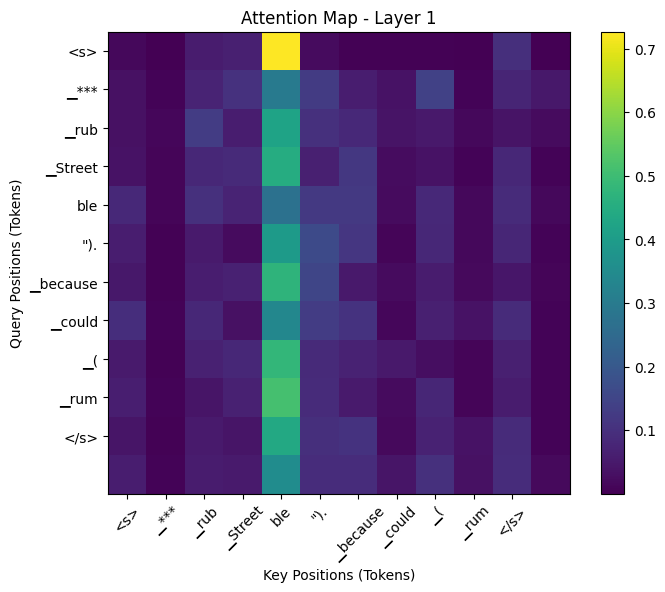

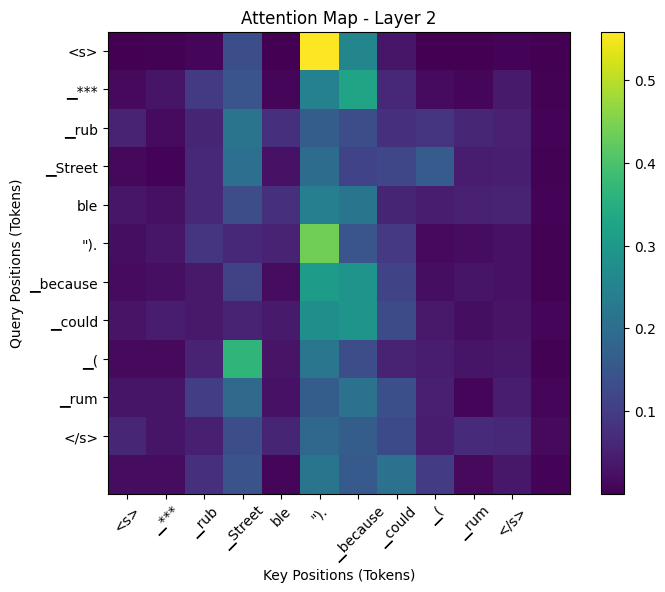

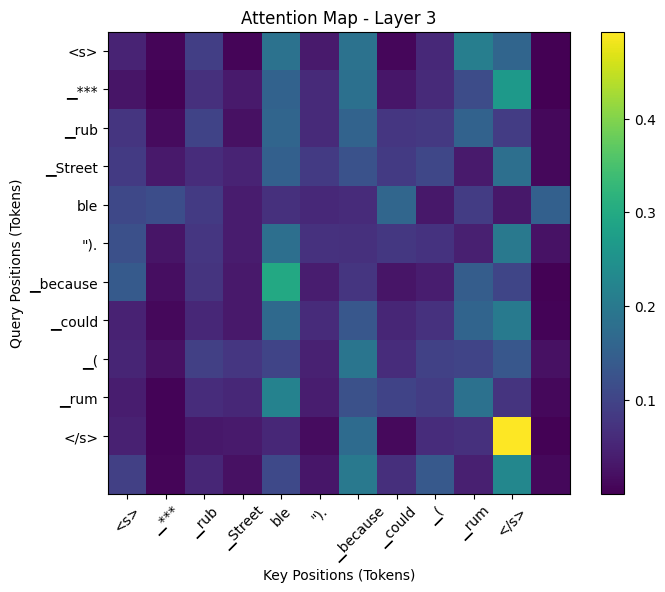

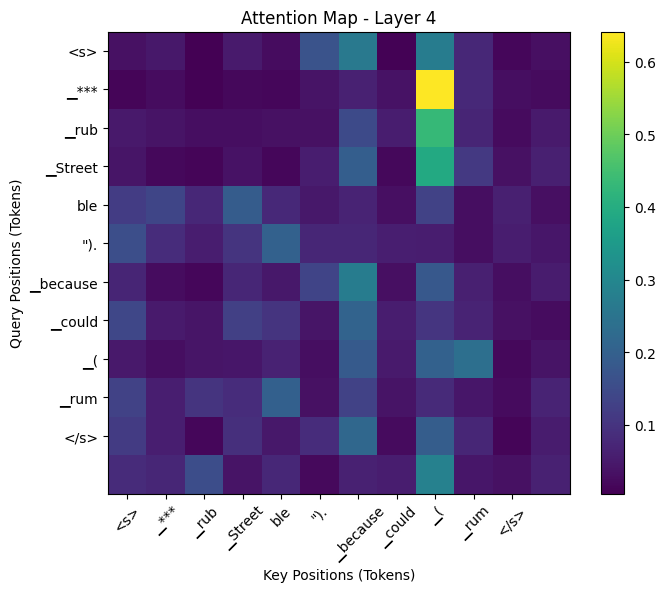

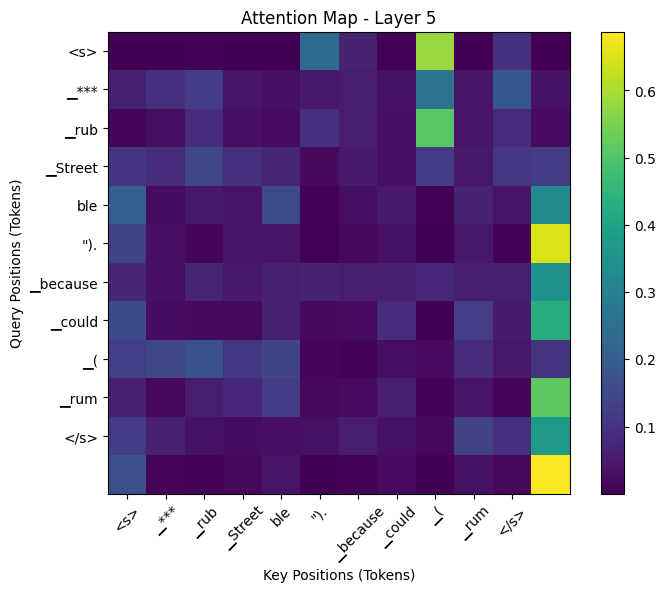

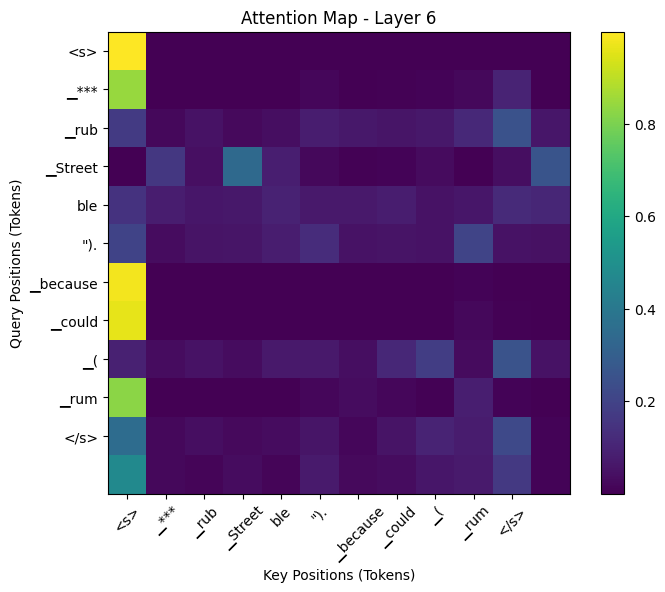

In [ ]:
Test_1 = """This film is one of my fondest childhood memories. Seeing the Muppets (at the height of their popularity) heading Hollywood, singing and dancing, with Miss Piggy googely-eying her beloved Kermit, Fozzie Bear doing his best as everyone's manager, and a generous cast of "extras" delivering a film that turned out to be "okey dokey".<br /><br />Kermit's melancholy ukulele number "Rainbow Connection" was nominated for an Oscar that year, but was beat out by Norma Rae's "It Goes Like It Goes". I'll pick Kermit's song any day! Get the kids and enjoy this timeless fantasy...someday they'll find it, the rainbow connections, the lovers, the dreamers and me!:"""
test_label = 0
print(f"Length of the test: {len(test_1)}")
text_tokens=text_tranform(test_1).to(device).unsqueeze(0)
print(text_tokens)
output,attn_maps=model(text_tokens.to(device), return_attn=True)
text_tokens_list = text_tokens.squeeze(0).tolist()
mapped_words=map_tokens_to_words(text_tokens_list,id_to_word)
print(len(mapped_words))


for layer_idx, attn_map in enumerate(attn_maps):
    plt.figure(figsize=(8, 6))
    plt.imshow(attn_map[0][0].detach().cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Map - Layer {layer_idx + 1}")
    plt.xlabel("Key Positions (Tokens)")
    plt.ylabel("Query Positions (Tokens)")
    plt.xticks(range(len(text_tokens_list)), mapped_words,rotation=45)
    plt.yticks(range(len(text_tokens_list)), mapped_words)
    plt.show()

#Testing

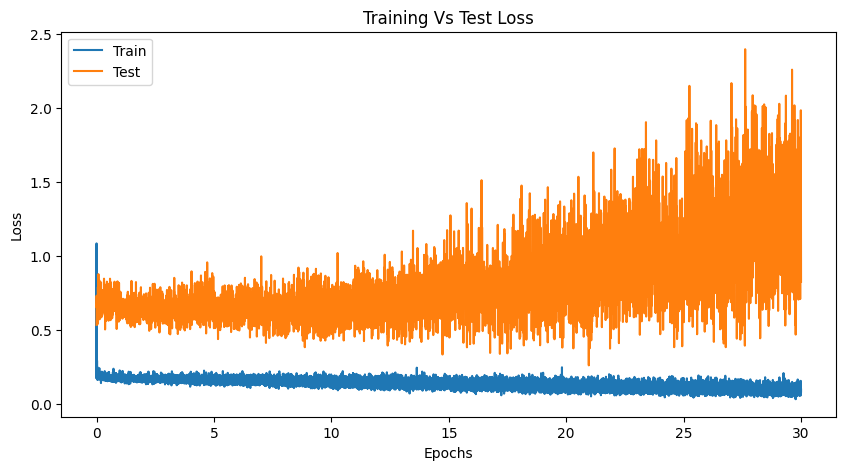

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

Max Test Accuracy 64.16%


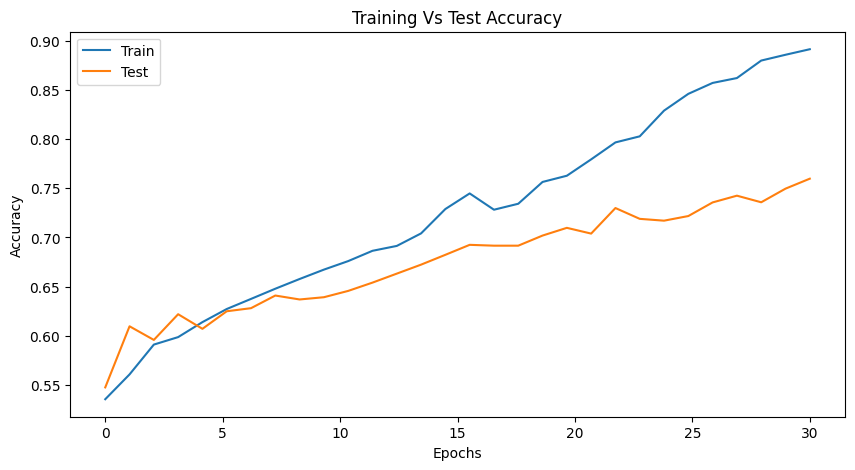

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_logger) * 100))

#Perbutation code for a single example

In [ ]:
import random
import string

def swap_word_letters(word: str) -> str:
    if len(word) <= 3:
        return word
    middle = list(word[1:-1])
    random.shuffle(middle)
    return word[0] + ''.join(middle) + word[-1]

def random_case_change(text: str) -> str:
    chars = list(text)
    num_changes = max(1, int(len(chars) * 0.2))
    positions = random.sample(range(len(chars)), num_changes)
    for pos in positions:
        if chars[pos].isalpha():
            chars[pos] = chars[pos].swapcase()
    return ''.join(chars)

def character_perturbations(text: str, perturbation_rate: float = 0.1) -> str:
    if not text or not isinstance(text, str):
        return text

    words = text.split()
    for i in range(len(words)):
        if random.random() < 0.2:
            words[i] = swap_word_letters(words[i])

    text = ' '.join(words)
    chars = list(text)
    num_perturbations = max(1, int(len(chars) * perturbation_rate))
    perturbation_types = ['swap', 'insert', 'delete', 'substitute', 'case_change']
    char_map = {
        'a': ['@', '4'],
        'e': ['3'],
        'i': ['1', '!'],
        'o': ['0'],
        's': ['5', '$'],
        't': ['7'],
        'b': ['6'],
        'g': ['9'],
        'l': ['1'],
        'z': ['2']
    }

    for _ in range(num_perturbations):
        if len(chars) < 2:
            continue
        pos = random.randint(0, len(chars) - 1)
        perturbation = random.choice(perturbation_types)

        if perturbation == 'swap' and pos < len(chars) - 1:
            chars[pos], chars[pos + 1] = chars[pos + 1], chars[pos]
        elif perturbation == 'insert':
            chars.insert(pos, random.choice(string.ascii_letters + string.digits + string.punctuation))
        elif perturbation == 'delete':
            chars.pop(pos)
        elif perturbation == 'substitute':
            char = chars[pos].lower()
            if char in char_map:
                chars[pos] = random.choice(char_map[char])
        elif perturbation == 'case_change' and chars[pos].isalpha():
            chars[pos] = chars[pos].swapcase()

    if random.random() < 0.3:
        return random_case_change(''.join(chars))

    return ''.join(chars)

if __name__ == "__main__":
    sample_text = "Hello, this is a test sentence."
    perturbed_text = character_perturbations(sample_text, perturbation_rate=0.2)
    print("Original text:", sample_text)
    print("Perturbed text:", perturbed_text)

Original text: Hello, this is a test sentence.
Perturbed text: Hello, this  sa teSt sEn7ence.


#Perbutation Testing

In [ ]:
hidden_size=512
model=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8,beta=0.2).to(device)
state_dict=torch.load('/content/tf_classifier_dynamicAttn_epoch_27.pth',map_location=torch.device('cuda'))
model.load_state_dict(state_dict)

Test_1 = """This film is one of my fondest childhood memories. Seeing the Muppets (at the height of their popularity) heading Hollywood, singing and dancing, with Miss Piggy googely-eying her beloved Kermit, Fozzie Bear doing his best as everyone's manager, and a generous cast of "extras" delivering a film that turned out to be "okey dokey".<br /><br />Kermit's melancholy ukulele number "Rainbow Connection" was nominated for an Oscar that year, but was beat out by Norma Rae's "It Goes Like It Goes". I'll pick Kermit's song any day! Get the kids and enjoy this timeless fantasy...someday they'll find it, the rainbow connections, the lovers, the dreamers and me!:"""
test_label=1
counter=0
perbute_text = Test_1
model.eval()
correct_pred=0
iter=0
prediction=1
while(test_label==prediction):
  perturbed_text=Test_1
  perturbed_text = character_perturbations(perturbed_text, perturbation_rate=0.2)
  text_tokens=text_tranform(perturbed_text).to(device).unsqueeze(0)
  output,attn_maps=model(text_tokens.to(device), return_attn=True)
  prediction=output.argmax(dim=1).item()
  if(prediction==1):
    correct_pred+=1
    co=correct_pred
  iter+=1
  perbute_text = perturbed_text
print(f"otal Iterations {iter} , Percentage {correct_pred/iter} ")

otal Iterations 6 , Percentage 0.8333333333333334 


In [ ]:
hidden_size=512
model=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8,beta=0.2).to(device)
state_dict=torch.load('/content/drive/MyDrive/Deep Learning/tf_classifier_dynamicAttn_epoch_33.pth',map_location=torch.device('cuda'))
model.load_state_dict(state_dict)

Test_1 = """This film is one of my fondest childhood memories. Seeing the Muppets (at the height of their popularity) heading Hollywood, singing and dancing, with Miss Piggy googely-eying her beloved Kermit, Fozzie Bear doing his best as everyone's manager, and a generous cast of "extras" delivering a film that turned out to be "okey dokey".<br /><br />Kermit's melancholy ukulele number "Rainbow Connection" was nominated for an Oscar that year, but was beat out by Norma Rae's "It Goes Like It Goes". I'll pick Kermit's song any day! Get the kids and enjoy this timeless fantasy...someday they'll find it, the rainbow connections, the lovers, the dreamers and me!:"""
test_label=1
counter=0
perbute_text = Test_1
model.eval()
correct_pred=0
iter=0
prediction=1
while(test_label==prediction):
  perturbed_text=Test_1
  perturbed_text = character_perturbations(perturbed_text, perturbation_rate=0.2)
  text_tokens=text_tranform(perturbed_text).to(device).unsqueeze(0)
  output,attn_maps=model(text_tokens.to(device), return_attn=True)
  prediction=output.argmax(dim=1).item()
  if(prediction==1):
    correct_pred+=1
    co=correct_pred
  iter+=1
  perbute_text = perturbed_text
print(f"otal Iterations {iter} , Percentage {correct_pred/iter} ")

otal Iterations 3 , Percentage 0.6666666666666666 


In [ ]:
perbute_text

'ThiS film IS one Of my FOndEst ChIldhoOd mresIome. Seeing thE Muppets (at The hEIghT of theIr PoPUlaRIty) heidang holLYwOod, singing and danCinG, wiTh msis Piggy goy-YeigoLNeg hEr bElevod Kermit, FoZZiE beAr Dinog his BEst as everyone\'s MEraaNg, and a GenErous csat OF "exTras" delIvERiNg a film ThAt tuRned out to bE "okeY dOKey".<BR /><br />KERmit\'s MElanchOly ukulele nebUmr "Rainbow Connection" Was neamnIotd for aN oscar that Year, but was beat ouT by Norma rea\'s "It GEOs Like It goes". I\'ll pICK KErmit\'s SonG aNy DAy! GeT the kids and enJoy This timelEss faaa.nYmedto.sS.y Tehy\'ll fnid it, The raiNbow ConneCTions, the loverS, The dReaMers and mE!:'

tensor([[    1,  9050,  1193, 13149,  6627, 15844,  7791, 15536,  5903,  2977,
             2]], device='cuda:0')
11


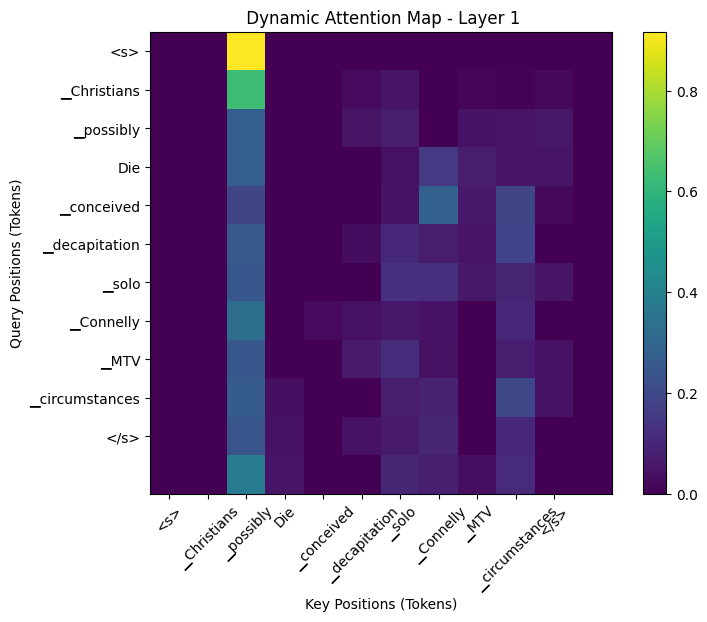

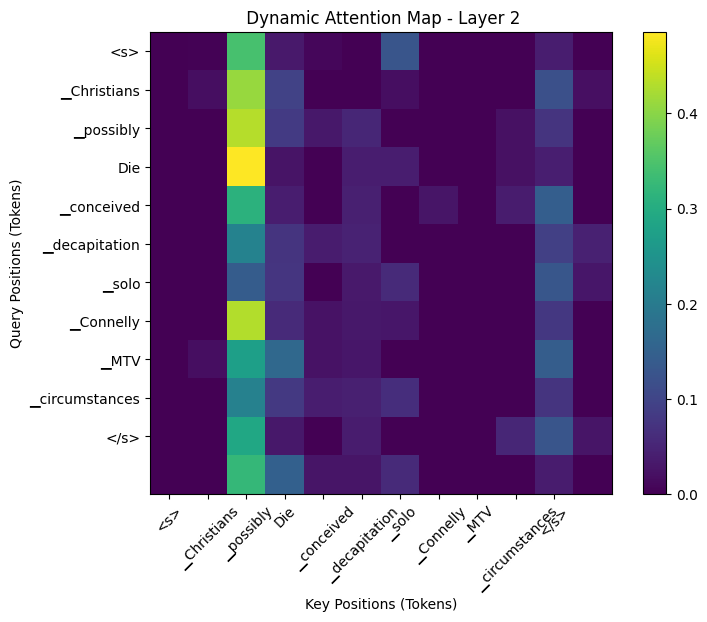

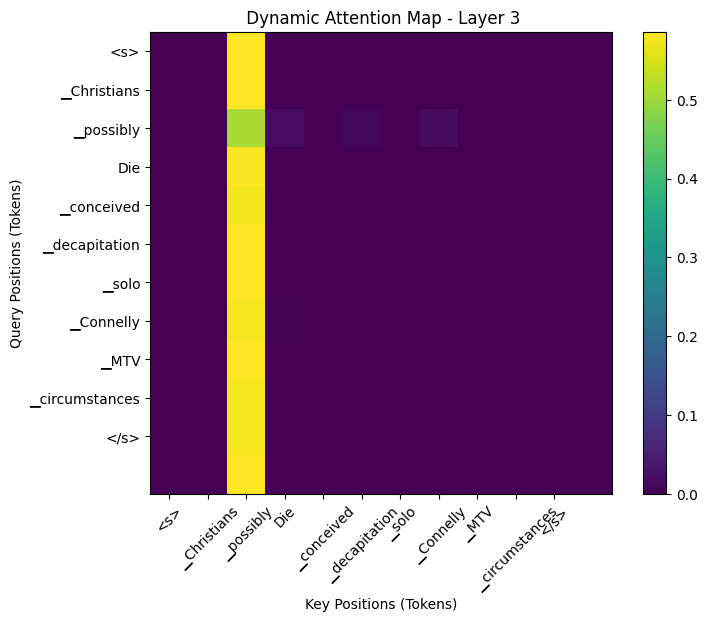

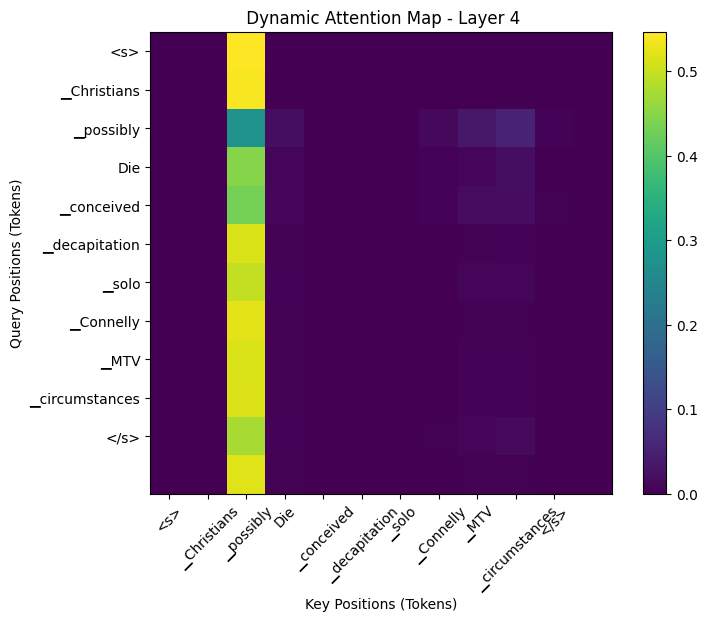

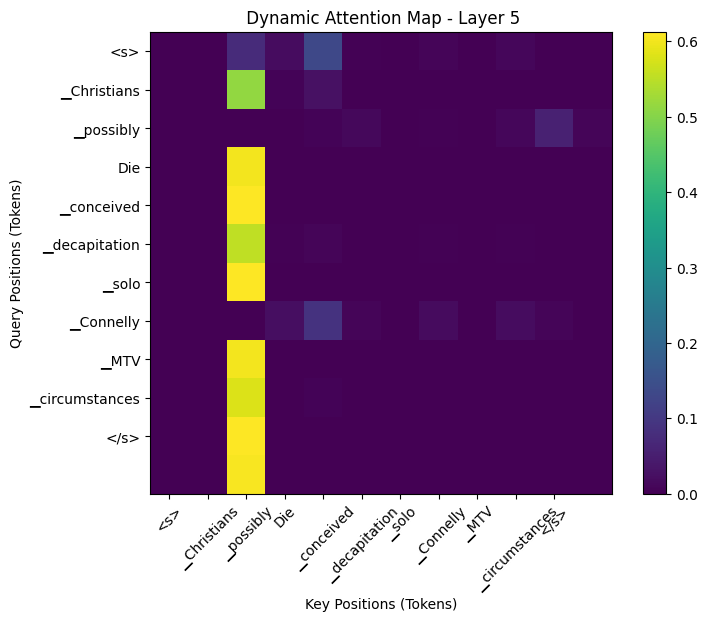

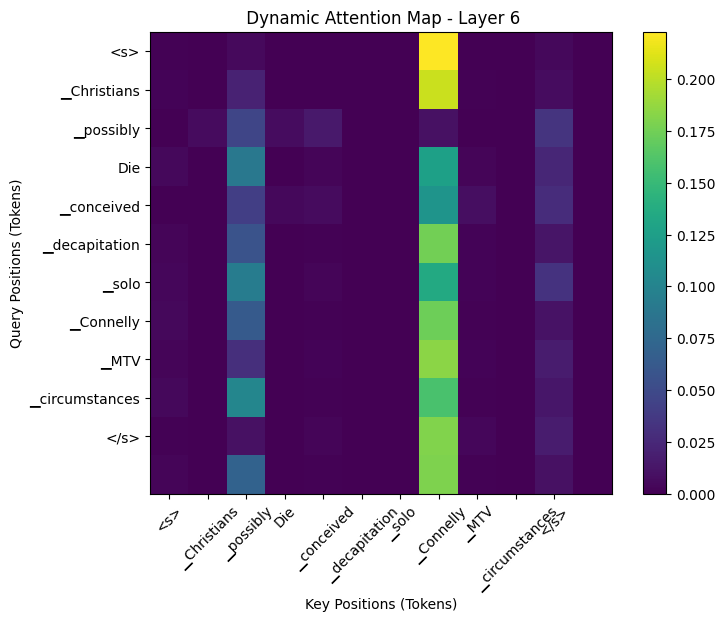

In [ ]:
# perbute_text
# print(f"Length of the test: {len(Test_1)}")
text_tokens=text_tranform(perbute_text).to(device).unsqueeze(0)
print(text_tokens)
output,attn_maps=model(text_tokens.to(device), return_attn=True)
text_tokens_list = text_tokens.squeeze(0).tolist()
mapped_words=map_tokens_to_words(text_tokens_list,id_to_word)
print(len(mapped_words))

for layer_idx, attn_map in enumerate(attn_maps):
    plt.figure(figsize=(8, 6))
    plt.imshow(attn_map[0][0].detach().cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title(f" Dynamic Attention Map - Layer {layer_idx + 1}")
    plt.xlabel("Key Positions (Tokens)")
    plt.ylabel("Query Positions (Tokens)")
    plt.xticks(range(len(text_tokens_list)), mapped_words,rotation=45)
    plt.yticks(range(len(text_tokens_list)), mapped_words)
    plt.show()

tensor([[    1,  9050,  1193, 13149,  6627, 15844,  7791, 15536,  5903,  2977,
             2]], device='cuda:0')
11


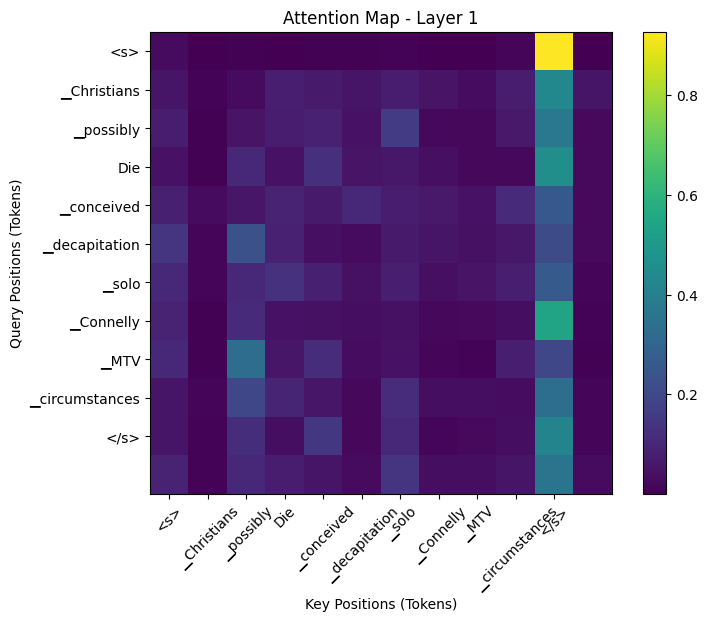

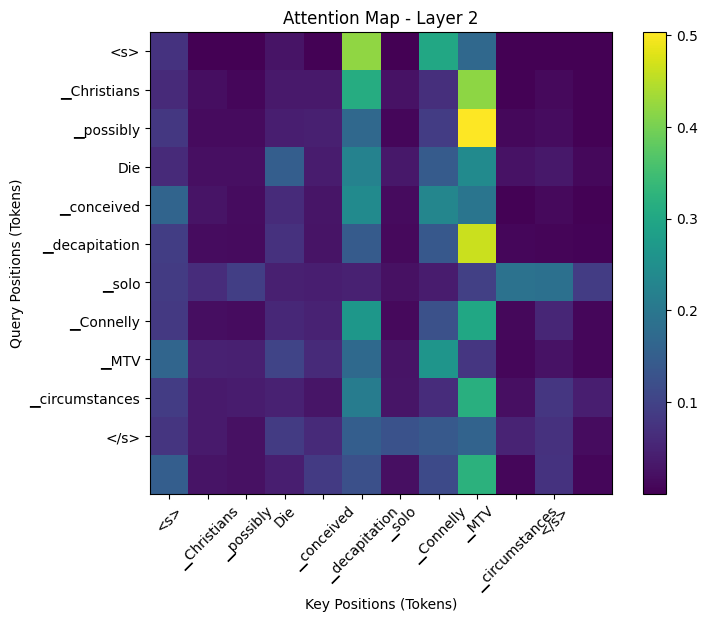

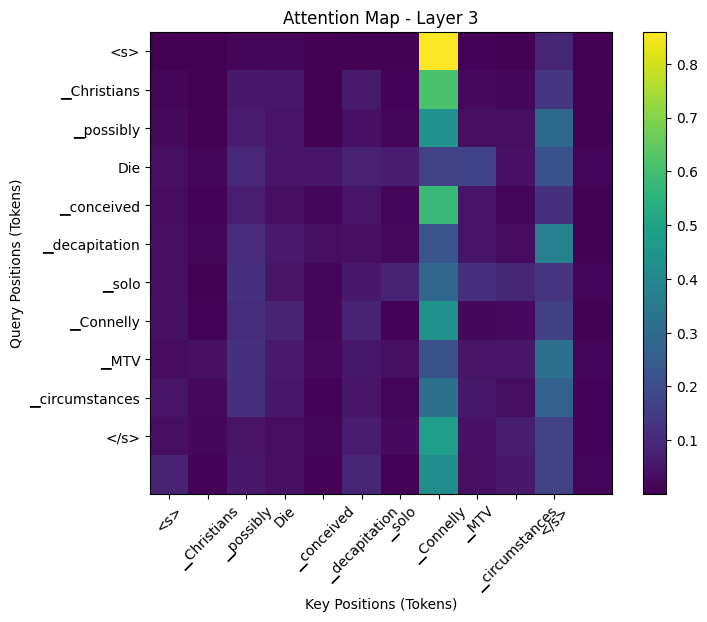

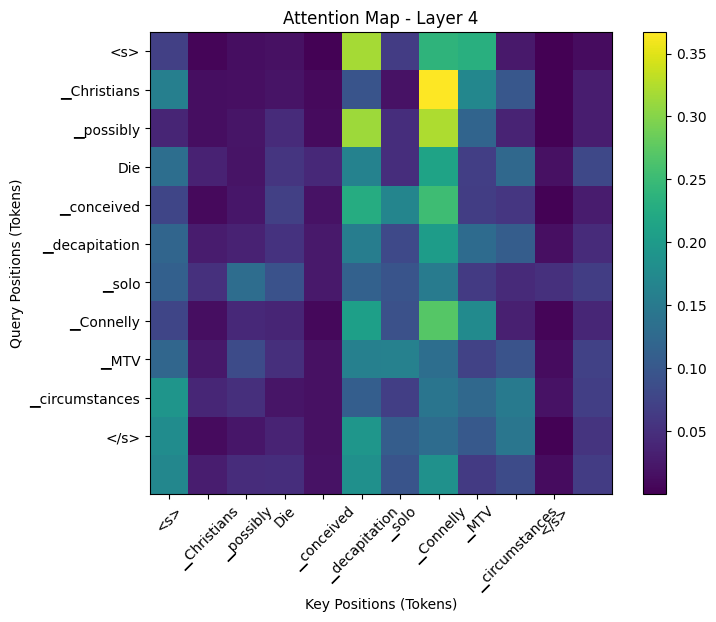

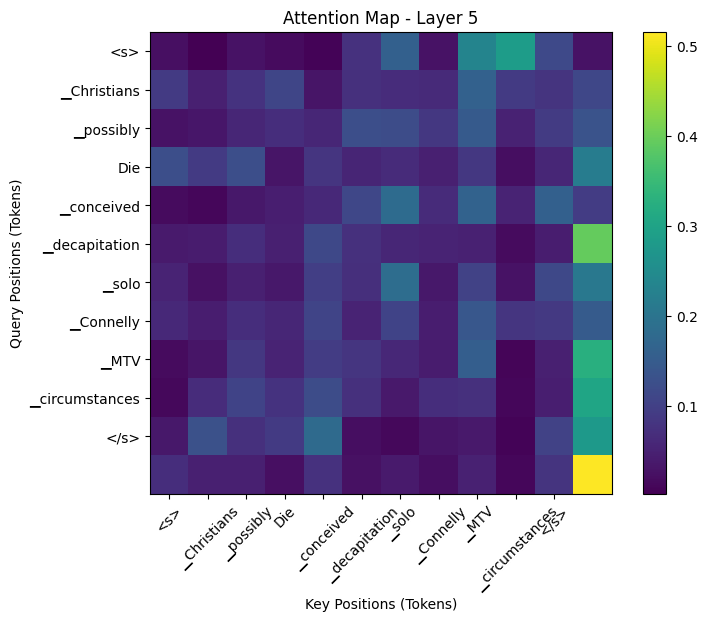

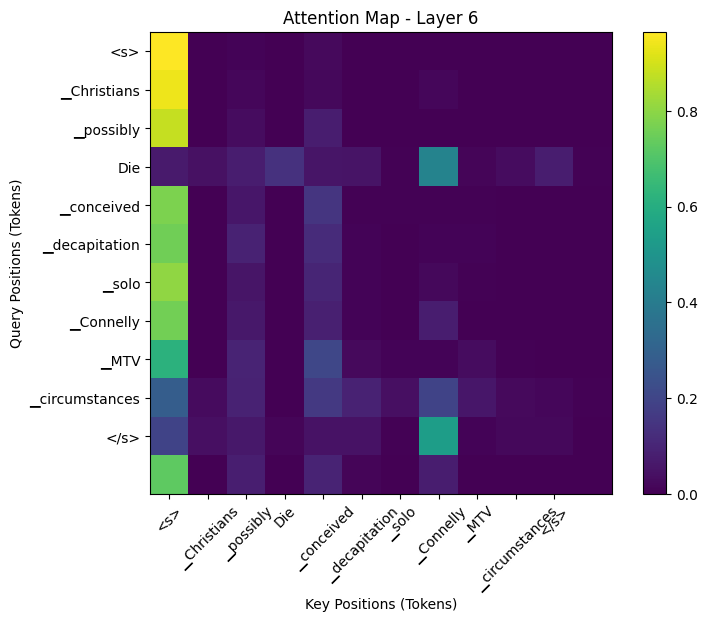

In [ ]:
# Test_1 = """This film is one of my fondest childhood memories. Seeing the Muppets (at the height of their popularity) heading Hollywood, singing and dancing, with Miss Piggy googely-eying her beloved Kermit, Fozzie Bear doing his best as everyone's manager, and a generous cast of "extras" delivering a film that turned out to be "okey dokey".<br /><br />Kermit's melancholy ukulele number "Rainbow Connection" was nominated for an Oscar that year, but was beat out by Norma Rae's "It Goes Like It Goes". I'll pick Kermit's song any day! Get the kids and enjoy this timeless fantasy...someday they'll find it, the rainbow connections, the lovers, the dreamers and me!:"""
# test_label = 0
# print(f"Length of the test: {len(test_1)}")
# Test_1 = character_perturbations(perbute_text, perturbation_rate=0.2)
text_tokens=text_tranform(perbute_text).to(device).unsqueeze(0)
print(text_tokens)
model=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8,beta=0.2).to(device)
state_dict=torch.load('/content/drive/MyDrive/Deep Learning/tf_classifier_dynamicAttn_epoch_33.pth',map_location=torch.device('cuda'))
model.load_state_dict(state_dict)
output,attn_maps=model(text_tokens.to(device), return_attn=True)
text_tokens_list = text_tokens.squeeze(0).tolist()
mapped_words=map_tokens_to_words(text_tokens_list,id_to_word)
print(len(mapped_words))

for layer_idx, attn_map in enumerate(attn_maps):
    plt.figure(figsize=(8, 6))
    plt.imshow(attn_map[0][0].detach().cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Map - Layer {layer_idx + 1}")
    plt.xlabel("Key Positions (Tokens)")
    plt.ylabel("Query Positions (Tokens)")
    plt.xticks(range(len(text_tokens_list)), mapped_words,rotation=45)
    plt.yticks(range(len(text_tokens_list)), mapped_words)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math

# DynamicAttention class as provided
class DynamicAttention(nn.Module):
    def __init__(self, numHeads, embedDim, beta):
        super(DynamicAttention, self).__init__()
        self.numHeads = numHeads
        self.embedDim = embedDim
        self.beta = beta
        self.headDim = embedDim // numHeads
        self.query = nn.Linear(embedDim, embedDim)
        self.key = nn.Linear(embedDim, embedDim)
        self.value = nn.Linear(embedDim, embedDim)
        self.finalProject = nn.Linear(embedDim, embedDim)

    def dynamicSel(self, n, mode="classification"):
        if mode == "classification":
            m = random.randint(max(1, int(0.1 * n)), max(1, int(0.2 * n)))
            return m
        elif mode == "generation":
            ma = max(1, 0.1 * n)
            mb = random.randint(ma, max(1, 0.2 * n))
            return ma, mb

    def forward(self, x, mode,return_attn=False):
        batchSize, seqLen, _ = x.shape  # (B,S,Em)
        q = self.query(x).view(batchSize, seqLen, self.numHeads, self.headDim).transpose(1, 2)  # (B,nH,S,Hd)
        k = self.key(x).view(batchSize, seqLen, self.numHeads, self.headDim).transpose(1, 2)  # (B,nH,S,Hd)
        v = self.value(x).view(batchSize, seqLen, self.numHeads, self.headDim).transpose(1, 2)  # (B,nH,S,Hd)
        score = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.headDim, dtype=torch.float32))  # (B,nH,S,S)
        attW = F.softmax(score, dim=-1)  # (B,nH,S,S)
        globAtt = attW.sum(dim=-1)  # (B,nH,S)
        totalAtt = globAtt.sum(dim=1)  # (B,S)

        if mode == "classification":
            m = self.dynamicSel(seqLen, mode)
            _, tokenT = torch.topk(totalAtt, m, dim=-1)
            tokenT = tokenT.tolist()
        elif mode == "generation":
            ma, mb = self.dynamicSel(seqLen, mode)
            _, tokenT = torch.topk(totalAtt, ma + mb, dim=-1)
            tokenT = tokenT[:, ma:].tolist()

        reAttw = attW.clone()
        for i in range(batchSize):
            for j in tokenT[i]:
                reAttw[i, :, :, j] *= self.beta
        reOut = torch.matmul(reAttw, v)  # (B,nH,S,S) * (B,nH,S,Hd) -> (B,S,Hd)
        reOut = reOut.transpose(1, 2).contiguous().view(batchSize, seqLen, self.embedDim)  # (B,S,Em)
        out = self.finalProject(reOut)  # (B,S,Em)
        if(return_attn):
          return out,attW
        return out

# SinusoidalPosEmb class as provided
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# TransformerBlock modified to use DynamicAttention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, beta=1.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size)
        self.dynamic_attn = DynamicAttention(numHeads=num_heads, embedDim=hidden_size, beta=beta)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LayerNorm(hidden_size), nn.ELU(), nn.Linear(hidden_size, hidden_size))

    def forward(self, x, key_padding_mask, mode="classification", return_attn=False):
        norm_x = self.norm1(x)
        attn_output,attnW = self.dynamic_attn(norm_x, mode,return_attn=True)  # Using DynamicAttention
        x = attn_output + x
        norm_x = self.norm2(x)
        mlp_output = self.mlp(norm_x)
        output = mlp_output + x
        if return_attn:
            return output, attnW  # Return attention output if requested
        return output

# Transformer model modified to use DynamicAttention
class Transformer(nn.Module):
    def __init__(self, num_emb, output_size, hidden_size, num_layers, num_heads, beta):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        self.blocks = nn.ModuleList([TransformerBlock(hidden_size, num_heads, beta) for _ in range(num_layers)])
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, mode="classification", return_attn=False):
        bs, _ = input_seq.shape
        key_padding_mask = input_seq == 0
        key_padding_mask = torch.cat((torch.zeros(bs, 1, device=input_seq.device).bool(), key_padding_mask), 1)
        input_embs = self.embedding(input_seq)
        input_embs = torch.cat((self.out_vec.expand(bs, 1, -1), input_embs), 1)
        bs, l, h = input_embs.shape
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        attn_map = []
        for block in self.blocks:
            embs, attn_weight = block(embs, key_padding_mask, mode, return_attn=True)
            attn_map.append(attn_weight)
        if return_attn:
            return self.fc_out(embs[:, 0]), attn_map
        return self.fc_out(embs[:, 0])
